### refining 3 timestep classifier
#### rows 0-2, ~27.4 years

In [150]:
import numpy as np
import pandas as pd

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix 

In [151]:
planets = pd.read_csv('3ts.csv', skipinitialspace=True)
print(planets.columns)

Index(['run', 'planet', 'initial e', 'final e', 'mean e', 'min e', 'max e',
       'sd e', 'initial pericenter', 'final pericenter', 'mean pericenter',
       'min pericenter', 'max pericenter', 'sd pericenter', 'initial jacobi',
       'final jacobi', 'mean jacobi', 'min jacobi', 'max jacobi', 'sd jacobi',
       'initial mhr1', 'final mhr1', 'mean mhr1', 'min mhr1', 'max mhr1',
       'sd mhr1', 'initial mhr2', 'final mhr2', 'mean mhr2', 'min mhr2',
       'max mhr2', 'sd mhr2', 'initial a1_ratio', 'final a1_ratio',
       'mean a1_ratio', 'min a1_ratio', 'max a1_ratio', 'sd a1_ratio',
       'initial a2_ratio', 'final a2_ratio', 'mean a2_ratio', 'min a2_ratio',
       'max a2_ratio', 'sd a2_ratio', 'initial mass1_ratio',
       'final mass1_ratio', 'mean mass1_ratio', 'min mass1_ratio',
       'max mass1_ratio', 'sd mass1_ratio', 'initial mass2_ratio',
       'final mass2_ratio', 'mean mass2_ratio', 'min mass2_ratio',
       'max mass2_ratio', 'sd mass2_ratio', 'end time', 'fate'],


###### started at ~84% accurate

In [152]:
fates = list(set(planets['fate']))

types = {fates[i] : i for i in range(len(fates))}

classes = []

for i in range(len(planets['fate'])):
    if planets['fate'][i] == "remaining":
        classes += [0]
    else:
        classes += [1]
        
classes = np.array(classes)

###### Training

In [153]:
features_train, features_test, classes_train, classes_test = train_test_split(planets, classes, test_size=0.3, random_state=7)

r = features_test['run'].to_numpy()
p = features_test['planet'].to_numpy()
e = features_test['end time'].to_numpy()
f = features_test['fate'].to_numpy()

In [154]:
ids_train = features_train['planet'].to_numpy()
features_train.drop(['run', 'planet', 'fate', 'end time'], axis=1, inplace=True)

cols = features_train.columns
features_train = features_train.to_numpy()

ids_test = features_test['planet'].to_numpy()
features_test.drop(['run', 'planet', 'fate', 'end time'], axis=1, inplace=True)
features_test = features_test.to_numpy()

/Users/neha/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [13]:
classifier = GradientBoostingClassifier(random_state=7)
classifier.fit(features_train, classes_train)

GradientBoostingClassifier(random_state=7)

In [48]:
classes_predict = classifier.predict( features_test )
print('Classifier is ', accuracy_score(classes_test, classes_predict) * 100, '% accurate on testing set' )

Classifier is  82.66666666666667 % accurate on testing set


###### Refining

In [26]:
param_grid = {'learning_rate': [0.02, 0.05, 0.07, 0.1, 0.12, 0.15, 0.17, 0.2],
              'max_depth': [4, 5, 6, 7, 8],
              'n_estimators': [50, 55, 60, 65, 70, 75, 80, 85, 90],
              'max_features': ['auto','sqrt','log2']}  
  
grid = GridSearchCV(GradientBoostingClassifier(), param_grid, refit = True, verbose = 1, n_jobs=-1) 
  
# fitting the model for grid search 
grid.fit(features_train, classes_train)

# print best parameter after tuning 
print(grid.best_params_) 
grid_predictions = grid.predict(features_train)
  
# print classification report 
print(classification_report(classes_train, grid_predictions)) 

Fitting 5 folds for each of 1080 candidates, totalling 5400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   57.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 12.6min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 16.6min
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed: 20.9min


{'learning_rate': 0.12, 'max_depth': 4, 'max_features': 'log2', 'n_estimators': 55}
              precision    recall  f1-score   support

           0       0.99      0.94      0.96       232
           1       0.97      0.99      0.98       468

    accuracy                           0.98       700
   macro avg       0.98      0.97      0.97       700
weighted avg       0.98      0.98      0.98       700



[Parallel(n_jobs=-1)]: Done 5400 out of 5400 | elapsed: 23.2min finished


In [155]:
classifier = GradientBoostingClassifier(learning_rate = 0.12, max_depth = 4, max_features = 'log2', n_estimators = 55, random_state=7)
classifier.fit(features_train, classes_train)

GradientBoostingClassifier(learning_rate=0.12, max_depth=4, max_features='log2',
                           n_estimators=55, random_state=7)

In [156]:
classes_predict = classifier.predict(features_test)
print('Classifier is ', accuracy_score(classes_test, classes_predict) * 100, '% accurate on testing set' )

Classifier is  85.66666666666667 % accurate on testing set




###### Feature importance (from old file)

In [157]:
feats=classifier.feature_importances_
inds=np.argsort(feats)[::-1]

for i in range(len(inds)):
    print(cols[inds[i]], feats[inds[i]])

sd e 0.08414368799066567
final mass2_ratio 0.07859322325128444
min a2_ratio 0.058907420290903095
sd pericenter 0.05653298393085778
initial a2_ratio 0.045898772925340225
min mass2_ratio 0.04225506174331996
min jacobi 0.04080173118178843
max mass2_ratio 0.04066378004512099
min mass1_ratio 0.0379397327988478
mean mass2_ratio 0.03108060273787851
initial mass2_ratio 0.02691383110154153
mean jacobi 0.02334197438934633
initial jacobi 0.019932259330454217
min pericenter 0.019343353452184117
final a2_ratio 0.01933756086745089
mean a2_ratio 0.018895185611692823
initial mass1_ratio 0.01757758674887191
final mass1_ratio 0.01654721515999024
max mhr2 0.016175020416015075
initial a1_ratio 0.015710287210858043
max mass1_ratio 0.0156312504775486
max e 0.015019670753576386
max a1_ratio 0.014812733221378249
sd a2_ratio 0.014390789605224772
mean pericenter 0.014238627943675732
mean mass1_ratio 0.014098424855828738
final e 0.013855967147327255
mean e 0.012610726340057785
min mhr1 0.012499411939623275
initi

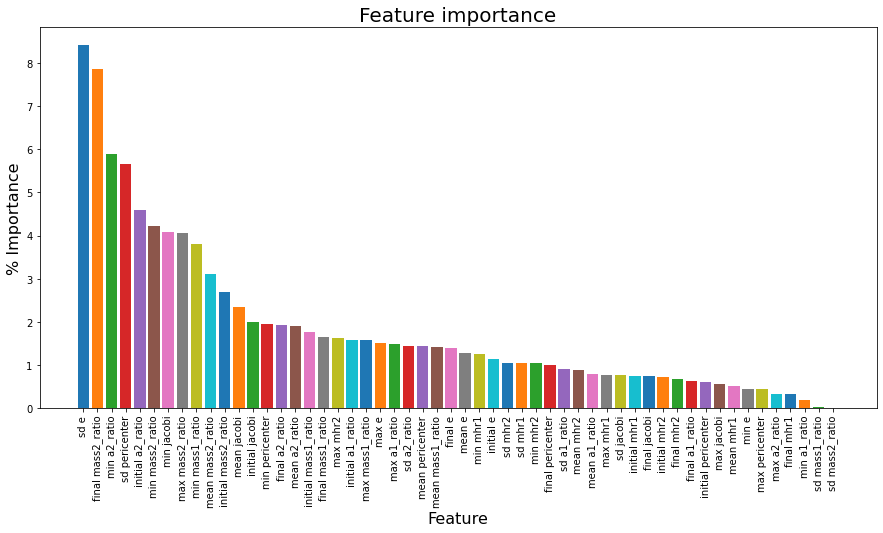

In [158]:
import matplotlib.pyplot as plt
import numpy as np
import pylab


f=plt.figure(figsize=(15,7))

for i in range(len(inds)):
    plt.bar(cols[inds[i]], feats[inds[i]] * 100)
    

 
plt.ylabel('% Importance', size=16)
plt.xlabel('Feature', size=16)
plt.title('Feature importance', size=20)
plt.xticks(rotation = 90)
plt.show()

In [172]:
# certainity/probability for misclassified ones, average percentage

inds = []

for i in range(0,len(classes_test)):
    if (classes_test[i] != classes_predict[i]):   # 0 = stable, 1 = unstable
        inds.append(i)

r = classifier.predict_proba(features_test)   # col 1 = stable
m = 0    # average percentage of certainty for misclassified ones


for i in range(0,len(r)):
    if (classes_test[i] != classes_predict[i]):
        print('Stable probability: ' + str(r[i][0]) + '. Unstable probability: ' + str(r[i][1]))
        if (classes_test[i] == 0):
            # print('Predicted: unstable. Actual: stable \n')
            m += r[i][1]
        else:
            # print('Predicted: stable. Actual: unstable \n')
            m += r[i][0]
            
m = m/len(inds)
print('\nAverage probability for misclassified objects: ' + str(m * 100))

Stable probability: 0.34369397324302964. Unstable probability: 0.6563060267569704
Stable probability: 0.27298773749875604. Unstable probability: 0.727012262501244
Stable probability: 0.45241255904061906. Unstable probability: 0.5475874409593809
Stable probability: 0.6730382348665391. Unstable probability: 0.3269617651334608
Stable probability: 0.18052074863823597. Unstable probability: 0.819479251361764
Stable probability: 0.2577164806008634. Unstable probability: 0.7422835193991366
Stable probability: 0.07114942430124194. Unstable probability: 0.9288505756987581
Stable probability: 0.05499385547576596. Unstable probability: 0.945006144524234
Stable probability: 0.12826410173295. Unstable probability: 0.87173589826705
Stable probability: 0.5914455555242883. Unstable probability: 0.4085544444757117
Stable probability: 0.7557522612118498. Unstable probability: 0.2442477387881502
Stable probability: 0.7123504185308693. Unstable probability: 0.28764958146913067
Stable probability: 0.849580

In [148]:
acu = 0    # actually unstable//actually stable
acs = 0

for i in range(0,len(classes_test)):
    if (classes_test[i] != classes_predict[i]):
        print('Run ' + str(r[i]) + ', Planet ' + str(p[i]))
        
        if classes_test[i] == 0 and classes_predict[i] == 1:
            print('Predicted: unstable. Actual: stable')
            acs+=1
        else:
            print('Predicted: stable. Actual: unstable')
            acu+=1
        print('Instability Time: ' + str(e[i]) + '\n')

    
print('Number of misclassified planets that are really stable: ' + str(acs))
print('Number of misclassified planets that are really unstable: ' + str(acu))

# think run 80, planet 5 shouldnt be accounted for since i think that was the one with the faulty data i had to delete

Run 28, Planet 2
Predicted: unstable. Actual: stable
Instability Time: 10000000.0

Run 88, Planet 6
Predicted: unstable. Actual: stable
Instability Time: 10000000.0

Run 88, Planet 10
Predicted: unstable. Actual: stable
Instability Time: 10000000.0

Run 72, Planet 6
Predicted: stable. Actual: unstable
Instability Time: 46493.800406300004

Run 98, Planet 10
Predicted: unstable. Actual: stable
Instability Time: 10000000.0

Run 29, Planet 10
Predicted: unstable. Actual: stable
Instability Time: 10000000.0

Run 32, Planet 10
Predicted: unstable. Actual: stable
Instability Time: 10000000.0

Run 91, Planet 7
Predicted: unstable. Actual: stable
Instability Time: 10000000.0

Run 95, Planet 2
Predicted: unstable. Actual: stable
Instability Time: 10000000.0

Run 100, Planet 8
Predicted: stable. Actual: unstable
Instability Time: 142341.85477489998

Run 31, Planet 9
Predicted: stable. Actual: unstable
Instability Time: 1111616.2498675

Run 59, Planet 8
Predicted: stable. Actual: unstable
Instabil

(-0.5, 3.0)

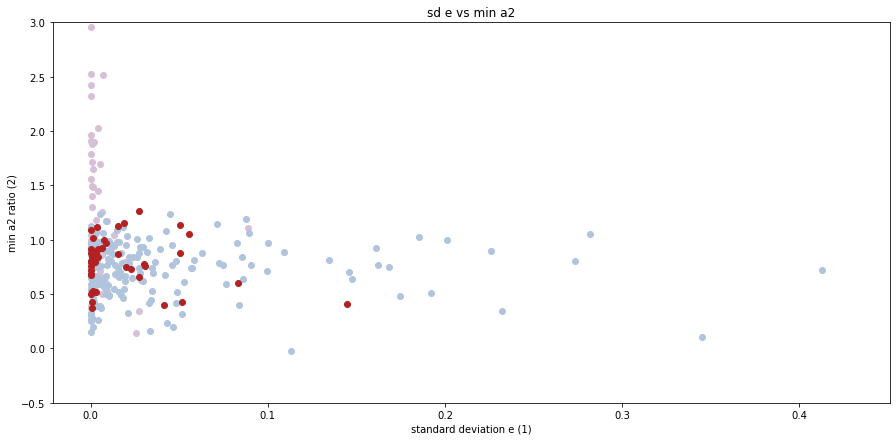

In [159]:
stable_x = []
unstable_x = []
misclassified_x = []
stable_y = []
unstable_y = []
misclassified_y = []
    
    
f=plt.figure(figsize=(15,7))

for i in range(len(features_test)):
    if (classes_test[i] == 0 and classes_predict[i] == 0):
        stable_x.append(features_test[i][5])
        stable_y.append(features_test[i][39])
    elif (classes_test[i] == 1 and classes_predict[i] == 1):
        unstable_x.append(features_test[i][5])
        unstable_y.append(features_test[i][39])
    else:
        misclassified_x.append(features_test[i][5])
        misclassified_y.append(features_test[i][39])

        
plt.scatter(stable_x, stable_y, color = 'thistle')
plt.scatter(misclassified_x, misclassified_y, color = 'firebrick', zorder = 2)
plt.scatter(unstable_x, unstable_y, color = 'lightsteelblue')

        
plt.ylabel('min a2 ratio (2)')
plt.xlabel('standard deviation e (1)')
plt.title('sd e vs min a2')
plt.ylim(-0.5, 3)